半开放建筑: x [-34052.97, 180882.88], y [-106.90, 144522.96]
实体建筑: x [-34107.94, 180874.27], y [-78.74, 144566.31]
道路: x [-22691.39, 170259.02], y [2033.22, 138916.04]
假山: x [-12764.09, 170971.87], y [41102.58, 122395.86]
水体: x [2729.99, 169897.47], y [5061.97, 135004.27]
植物: x [-31899.02, 176777.20], y [2435.43, 141755.08]


C:\Users\90828\AppData\Local\Temp\ipykernel_21540\1092416709.py:111: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig("yuanlin_elements_map_with_plants.png", dpi=300, bbox_inches='tight')
E:\anaconda3\envs\py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


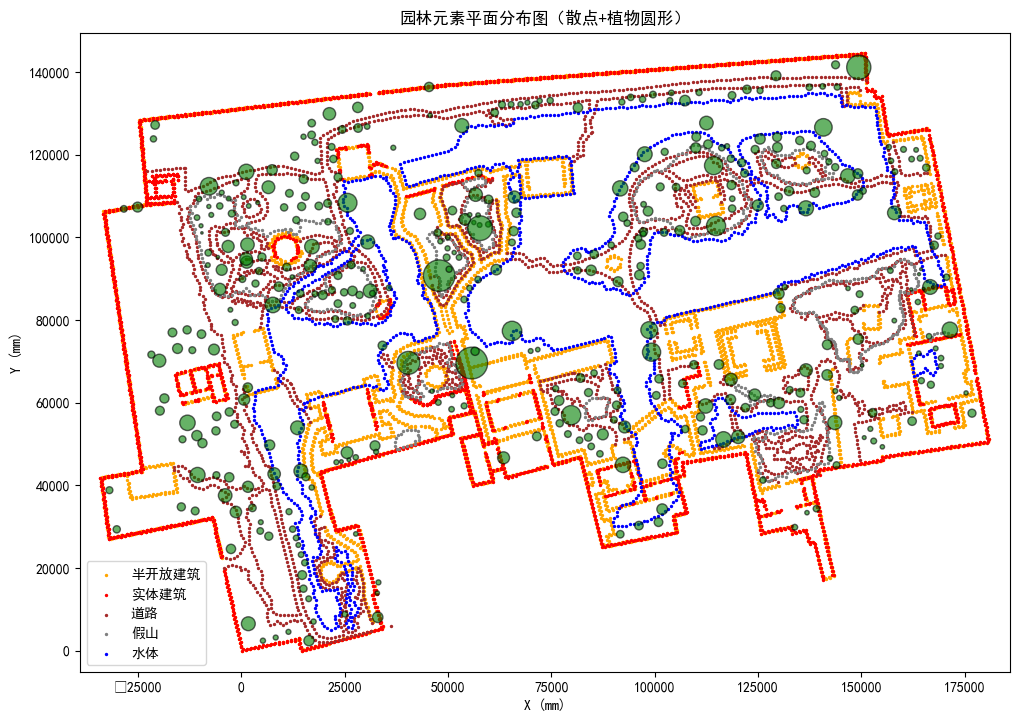

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']
# -----------------------
# 解析坐标字符串 {x, y, z} -> [x, y]
# -----------------------
def parse_point(s):
    s = re.sub(r"[{}]", "", str(s))
    parts = s.split(",")
    if len(parts) < 2:
        return [np.nan, np.nan]
    try:
        return [float(parts[0]), float(parts[1])]
    except:
        return [np.nan, np.nan]

# -----------------------
# Excel 文件路径和 sheet 名
# -----------------------
file = "D:/Cache files/QQ/赛题F江南古典园林美学特征建模附件资料/1. 拙政园/4-拙政园数据坐标.xlsx"
sheet_names = ["半开放建筑", "实体建筑", "道路", "假山", "水体", "植物"]

# -----------------------
# 读取数据并转换为坐标
# -----------------------
data_dict = {}
for sheet in sheet_names:
    df = pd.read_excel(file, sheet_name=sheet)
    if sheet == "植物":
        # 植物中心坐标在第一列
        coords = df.iloc[:, 0].dropna().apply(parse_point).tolist()
    else:
        # 其他元素取第二列（不区分线段）
        coords = df.iloc[:, 1].dropna().apply(parse_point).tolist()
    coords = np.array(coords)
    coords = coords[~np.isnan(coords).any(axis=1)]
    data_dict[sheet] = coords

# -----------------------
# 绘图颜色字典
# -----------------------
color_dict = {
    "半开放建筑": "orange",
    "实体建筑": "red",
    "道路": "brown",
    "假山": "gray",
    "水体": "blue",
    "植物": "green"
}

plt.figure(figsize=(12, 12))
ax = plt.gca()

# -----------------------
# 计算所有元素坐标范围，排除 NaN
# -----------------------
all_coords = np.vstack([coords for coords in data_dict.values() if coords.shape[0] > 0])
x_min, x_max = np.min(all_coords[:, 0]), np.max(all_coords[:, 0])
y_min, y_max = np.min(all_coords[:, 1]), np.max(all_coords[:, 1])

# -----------------------
# 绘制每个元素
# -----------------------
for sheet, coords in data_dict.items():
    if coords.shape[0] == 0:
        continue
    x, y = coords[:, 0], coords[:, 1]

    # 打印每个元素的范围
    print(f"{sheet}: x [{x.min():.2f}, {x.max():.2f}], y [{y.min():.2f}, {y.max():.2f}]")

    if sheet == "植物":
        df = pd.read_excel(file, sheet_name=sheet)
        centers = df.iloc[:, 0].dropna().apply(parse_point).tolist()
        diameters = df.iloc[:, 1].dropna().tolist()
        for (cx, cy), d in zip(centers, diameters):
            radius = d / 2  # 冠径/2 = 半径
            circle = plt.Circle((cx, cy), radius, facecolor=color_dict[sheet], edgecolor='black', alpha=0.6)
            ax.add_patch(circle)
    else:
        ax.scatter(x, y, color=color_dict[sheet], s=2, label=sheet)
        # ax.plot(x, y, color=color_dict[sheet], label=sheet)
        

# -----------------------
# 设置坐标范围
# -----------------------
ax.set_xlim(x_min - 5000, x_max + 5000)
ax.set_ylim(y_min - 5000, y_max + 5000)
ax.set_aspect('equal', adjustable='box')

# -----------------------
# 去重图例
# -----------------------
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# -----------------------
# 坐标轴与标题
# -----------------------
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("园林元素平面分布图（散点+植物圆形）")

# -----------------------
# 保存并显示
# -----------------------
plt.savefig("yuanlin_elements_map_with_plants.png", dpi=300, bbox_inches='tight')
plt.show()


KeyboardInterrupt: 

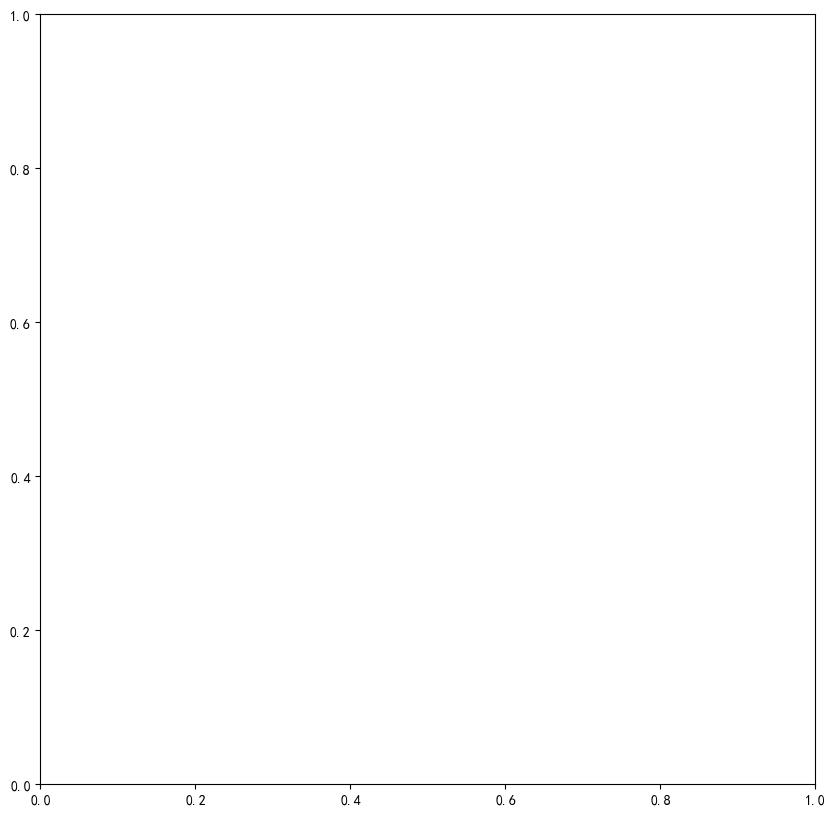

In [17]:
# 文件名：01_visualize_garden.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import ast

# ========== 工具函数 ==========
def parse_point(s):
    """解析形如 {x,y,0} 的字符串为 (x, y)"""
    if isinstance(s, str):
        s = s.strip().replace("{", "").replace("}", "")
        vals = [float(v) for v in s.split(",")]
        return vals[0], vals[1]
    return None

def parse_group_data(df):
    """将类似 {0;i}, j.{x,y,0} 的分组数据转为列表"""
    groups = {}
    current_group = None
    for item in df.iloc[:,0]:
        #  is string and starts with '{0;', ignore spaces
        if isinstance(item, str) and item.strip().startswith("{0;"):
            current_group = item
            groups[current_group] = []
        else:
            if isinstance(item, str) and "," in item:
                _, point_str = item.split(",", 1)
                groups[current_group].append(parse_point(point_str))
    return groups

# ========== 数据读取 ==========
file = "D:/Cache files/QQ/赛题F江南古典园林美学特征建模附件资料/1. 拙政园/4-拙政园数据坐标.xlsx"
sheets = ["半开放建筑", "实体建筑", "道路", "假山", "水体", "植物"]

# 植物
df_plants = pd.read_excel(file, sheet_name="植物")
plants = [(parse_point(df_plants.iloc[i,0]), df_plants.iloc[i,1]) for i in range(1, len(df_plants))]

# 其它要素
elements = {}
for sheet in sheets[:-1]:  # 前5类
    df = pd.read_excel(file, sheet_name=sheet)
    groups = parse_group_data(df)
    elements[sheet] = groups

# ========== 可视化 ==========
plt.figure(figsize=(10, 10))

# 绘制植物
for (x,y), r in plants:
    circle = plt.Circle((x,y), r, color="green", alpha=0.4)
    plt.gca().add_patch(circle)

# 绘制其它要素
colors = {
    "半开放建筑": "orange",
    "实体建筑": "brown",
    "道路": "gray",
    "假山": "black",
    "水体": "blue"
}
for name, groups in elements.items():
    for _, pts in groups.items():
        xs, ys = zip(*pts)
        plt.plot(xs, ys, color=colors[name], label=name)

plt.title("园林平面图")
plt.axis("equal")
plt.legend()
plt.show()
